---
title: "San Francisco Crime Analysis in Physical and Social Environment"
author: "Tianxiao Chen"
date: "2023-04-25"
categories: [spatial, analysis]
format: 
  html:
    code-fold: true
    message: false
jupyter: python3
---

# Environment Setting

### Preparation for data process

In [ ]:
# Data manipulation libraries
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Timer
from tqdm import tqdm, tqdm_notebook

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Model support functions
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler 
from pprint import pprint
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Geo-related libraries
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import contextily as ctx
import geofeather
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from shapely import wkt

import osmnx

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1HJBU_-Yg_ylAzab8v11l1wcYEwBhO41-/view?usp=share_link
id = "1HJBU_-Yg_ylAzab8v11l1wcYEwBhO41-"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('Police_Department_Incident_Reports__2018_to_Present.csv')

### Data brief review

In [ ]:
#load crime data
crime_df = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
crime_df.head()

Incident Datetime Incident Date Incident Time  Incident Year  \
0  2023/03/13 11:41:00 PM    2023/03/13         23:41           2023   
1  2023/03/01 05:02:00 AM    2023/03/01         05:02           2023   
2  2023/03/13 01:16:00 PM    2023/03/13         13:16           2023   
3  2023/03/13 10:59:00 AM    2023/03/13         10:59           2023   
4  2023/03/14 06:44:00 PM    2023/03/14         18:44           2023   

  Incident Day of Week         Report Datetime        Row ID  Incident ID  \
0               Monday  2023/03/13 11:41:00 PM  125373607041      1253736   
1            Wednesday  2023/03/11 03:40:00 PM  125379506374      1253795   
2               Monday  2023/03/13 01:17:00 PM  125357107041      1253571   
3               Monday  2023/03/13 11:00:00 AM  125355107041      1253551   
4              Tuesday  2023/03/14 06:45:00 PM  125402407041      1254024   

   Incident Number  CAD Number  ... Longitude Point Neighborhoods  \
0        230167874         NaN  ...       NaN   NaN           NaN   
1        236046151         NaN  ...       NaN   NaN           NaN   
2        220343896         NaN  ...       NaN   NaN           NaN   
3        230174885         NaN  ...       NaN   NaN           NaN   
4        230176728         NaN  ...       NaN   NaN           NaN   

   ESNCAG - Boundary File  \
0                     NaN   
1                     NaN   
2                     NaN   
3                     NaN   
4                     NaN   

  Central Market/Tenderloin Boundary Polygon - Updated  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

  Civic Center Harm Reduction Project Boundary HSOC Zones as of 2018-06-05  \
0                                          NaN                         NaN   
1                                          NaN                         NaN   
2                                          NaN                         NaN   
3                                          NaN                         NaN   
4                                          NaN                         NaN   

  Invest In Neighborhoods (IIN) Areas Current Supervisor Districts  \
0                                 NaN                          NaN   
1                                 NaN                          NaN   
2                                 NaN                          NaN   
3                                 NaN                          NaN   
4                                 NaN                          NaN   

   Current Police Districts  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 35 columns]

In [ ]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716680 entries, 0 to 716679
Data columns (total 35 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Incident Datetime                                     716680 non-null  object 
 1   Incident Date                                         716680 non-null  object 
 2   Incident Time                                         716680 non-null  object 
 3   Incident Year                                         716680 non-null  int64  
 4   Incident Day of Week                                  716680 non-null  object 
 5   Report Datetime                                       716680 non-null  object 
 6   Row ID                                                716680 non-null  int64  
 7   Incident ID                                           716680 non-null  int64  
 8   Incident Number                             

In [ ]:
#convert the pandas file to geopandas file
crime_df_geo = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.Longitude, crime_df.Latitude), crs={'init' :'epsg:4326'})
crime_df_geo.info()

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 716680 entries, 0 to 716679
Data columns (total 36 columns):
 #   Column                                                Non-Null Count   Dtype   
---  ------                                                --------------   -----   
 0   Incident Datetime                                     716680 non-null  object  
 1   Incident Date                                         716680 non-null  object  
 2   Incident Time                                         716680 non-null  object  
 3   Incident Year                                         716680 non-null  int64   
 4   Incident Day of Week                                  716680 non-null  object  
 5   Report Datetime                                       716680 non-null  object  
 6   Row ID                                                716680 non-null  int64   
 7   Incident ID                                           716680 non-null  int64   
 8   Incident Number           

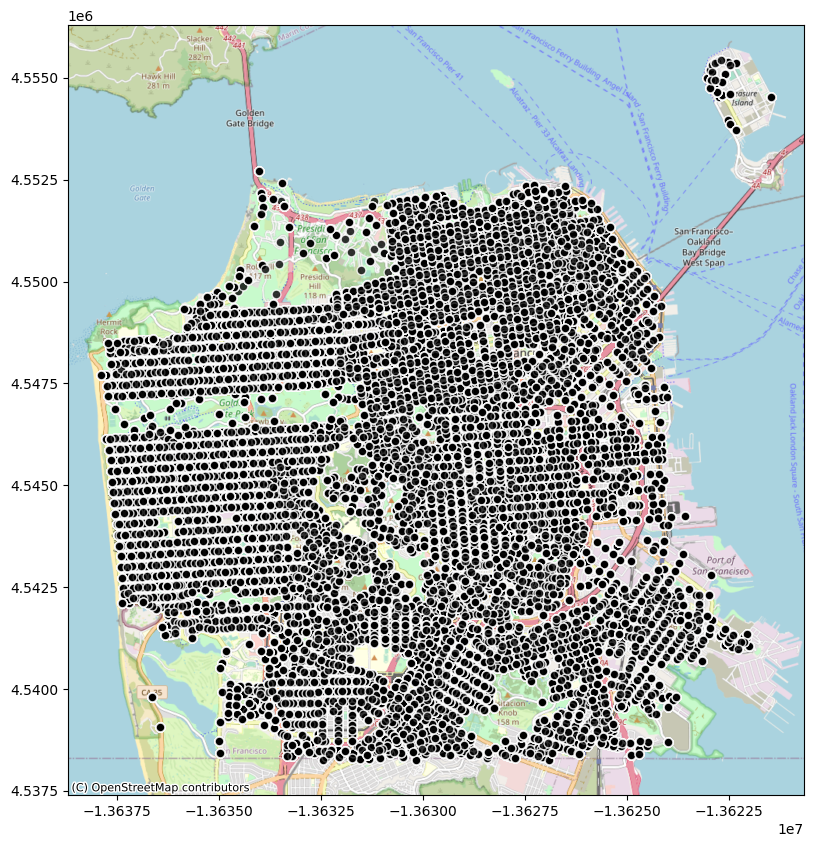

In [ ]:
#intial visualization
fig, ax = plt.subplots(figsize=(12, 10))
crime_df_geo.to_crs(epsg=3857).plot(ax = ax,
                figsize=(12,12),
                markersize=40,
               color="black",
               edgecolor="white",
               alpha=0.8,
               marker="o"
            );
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Prev Analysis

### The number of crime in different categories

In [ ]:
#calculate the number of crime in different categories
q1 = crime_df.groupby('Incident Category').size().reset_index(name='count')
q1 = q1.sort_values(by='count', ascending=False)
q1.head(10)

Incident Category   count
18        Larceny Theft  218642
29  Other Miscellaneous   49878
21   Malicious Mischief   48503
1               Assault   43600
26         Non-Criminal   42605
2              Burglary   40225
24  Motor Vehicle Theft   36698
33    Recovered Vehicle   27881
12                Fraud   22995
20        Lost Property   20831

<Figure size 640x480 with 0 Axes>

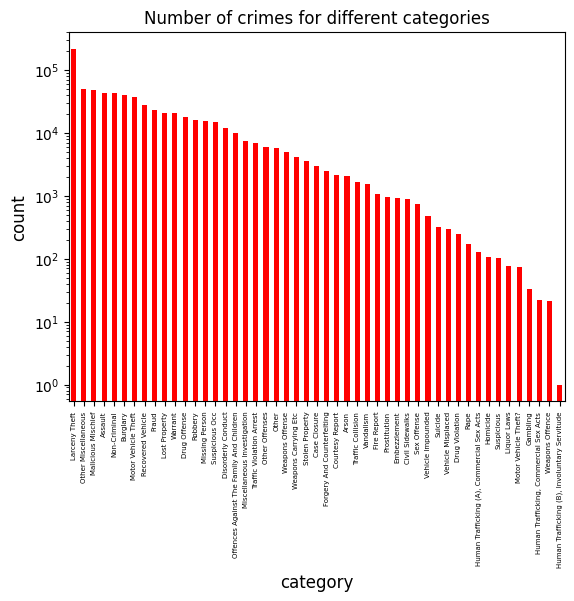

In [ ]:
#data visualization
plt.figure()
ax = q1.plot(kind = 'bar', x = 'Incident Category' , y = 'count', logy = True, color = 'red', legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('category',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('Number of crimes for different categories')
display()

#### From the number of crime in different categories, we can find that 'Larceny Theft' top the rank and significantly outnumber other kinds, folliwing 'Malicious Mischief' and 'Assault'. the large number of theft, for one things, results from the many places where it can happen. For another, the change in Califonia policy for the determination of crime also lower cost of crime that causes lower property damage.

### The number of crime in different PdDistricts

In [ ]:
#calculate the number of crime in different PdDistricts
q2 = crime_df.groupby('Police District').size().reset_index(name='count')
q2 = q2.sort_values(by='count', ascending=False)
q2.head(10)

Police District   count
1          Central  107239
4         Northern   97302
3          Mission   89637
8         Southern   86064
10      Tenderloin   69222
0          Bayview   63678
2        Ingleside   54276
9          Taraval   50327
7         Richmond   44702
6             Park   32995

<Figure size 640x480 with 0 Axes>

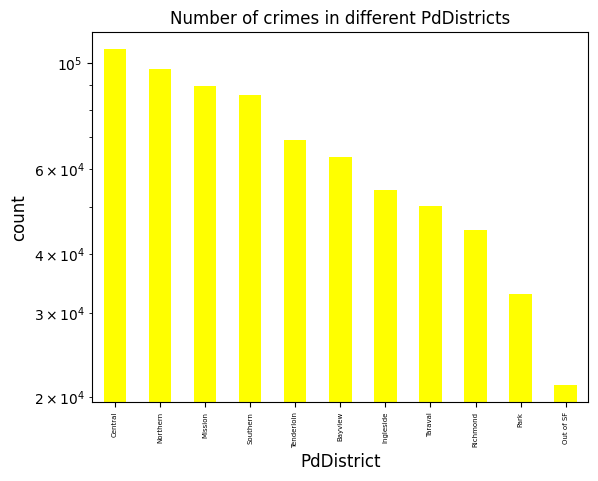

In [ ]:
#data visualization
plt.figure()
ax = q2.plot(kind = 'bar', x = 'Police District' , y = 'count', logy = True, color = 'yellow', legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('PdDistrict',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('Number of crimes in different PdDistricts')
display()

### The trend of number of crime from 2018 to 2022

In [ ]:
# switch the form of time data for easier analysis 
crime_df[['year','month', 'day']] = crime_df['Incident Date'].str.split('/', expand=True)
crime_df['day'] = pd.to_numeric(crime_df['day'])
crime_df['month'] = pd.to_numeric(crime_df['month'])
crime_df['year'] = pd.to_numeric(crime_df['year'])
crime_df[['hour','minute']] = crime_df['Incident Time'].str.split(':', expand=True)
crime_df['hour'] = pd.to_numeric(crime_df['hour'])
crime_df['minute'] = pd.to_numeric(crime_df['minute'])

In [ ]:
#select the data from 2018 to 2022
year = [2018,2019,2020,2021,2022]
crime_df_new = crime_df[crime_df.year.isin(year)]
crime_df_new.head()

Incident Datetime Incident Date Incident Time  Incident Year  \
11  2022/06/27 12:00:00 PM    2022/06/27         12:00           2022   
25  2022/05/15 04:00:00 PM    2022/05/15         16:00           2022   
35  2018/09/03 09:00:00 AM    2018/09/03         09:00           2018   
36  2019/01/13 02:00:00 PM    2019/01/13         14:00           2019   
37  2018/11/02 12:00:00 PM    2018/11/02         12:00           2018   

   Incident Day of Week         Report Datetime        Row ID  Incident ID  \
11               Monday  2023/03/15 05:20:00 PM  125439371000      1254393   
25               Sunday  2022/05/17 07:32:00 PM  116100671000      1161006   
35               Monday  2018/09/03 01:17:00 PM   73006271000       730062   
36               Sunday  2019/01/14 12:10:00 PM   75982071000       759820   
37               Friday  2018/11/03 02:21:00 PM   73376171000       733761   

    Incident Number   CAD Number  ... HSOC Zones as of 2018-06-05  \
11        230184129  230742480.0  ...                         NaN   
25        226100018          NaN  ...                         NaN   
35        186245900          NaN  ...                         NaN   
36        196009821          NaN  ...                         NaN   
37        180833020          NaN  ...                         NaN   

   Invest In Neighborhoods (IIN) Areas Current Supervisor Districts  \
11                                 NaN                          3.0   
25                                 NaN                          NaN   
35                                 NaN                          NaN   
36                                 NaN                          NaN   
37                                 NaN                          NaN   

    Current Police Districts                     geometry  year month day  \
11                       6.0  POINT (-122.40823 37.78736)  2022     6  27   
25                       NaN                  POINT EMPTY  2022     5  15   
35                       NaN                  POINT EMPTY  2018     9   3   
36                       NaN                  POINT EMPTY  2019     1  13   
37                       NaN                  POINT EMPTY  2018    11   2   

   hour  minute  
11   12       0  
25   16       0  
35    9       0  
36   14       0  
37   12       0  

[5 rows x 41 columns]

In [ ]:
# calculate the monthly number of crime from 2018 to 2022 
q3 = crime_df_new.groupby(['year','month']).size().reset_index(name='count')
q3 = q3.sort_values(by=['year','month'], ascending=True)
q3['year-month'] = q3['year'].astype(str) + '-' + q3['month'].astype(str).str.zfill(2)
q3.head()

year  month  count year-month
0  2018      1  13274    2018-01
1  2018      2  11727    2018-02
2  2018      3  12565    2018-03
3  2018      4  12421    2018-04
4  2018      5  12847    2018-05

<Figure size 640x480 with 0 Axes>

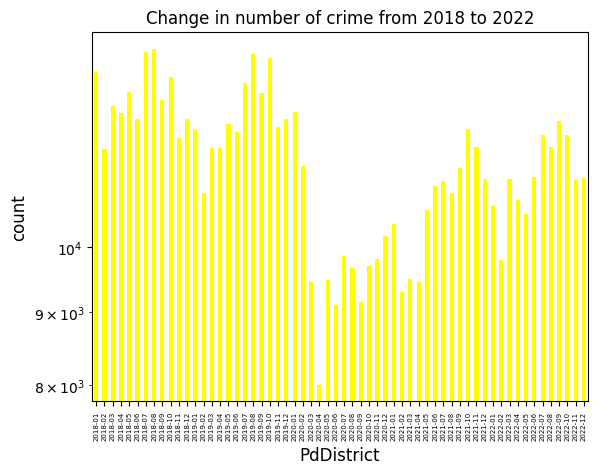

In [ ]:
#data visualization
plt.figure()
ax = q3.plot(kind = 'bar', x = 'year-month' , y = 'count', logy = True, color = 'yellow', legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('PdDistrict',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('Change in number of crime from 2018 to 2022')
display()

#### From the bar chart of crime number based on the month, first of all, we can find that the crime nunmber show a seasonality, which increase from every year's March and reach a peak in September and then drop till next year's March. Also, we can find a sharp decrease at the begining of 2020. We can assume that this situation was highly influenced by Covid-19, and the influence is gradually weakened after begining of 2020 but count of crime is less than pre-covid anually.

### The hourly distribution of crime in a day?

In [ ]:
# count the number of crime in different hours
q4 = crime_df_new.groupby('hour').size().reset_index(name = 'count')
q4 = q4.sort_values(by='hour', ascending=True)
q4.head()

hour  count
0     0  37081
1     1  18247
2     2  15878
3     3  12917
4     4  10887

<Figure size 640x480 with 0 Axes>

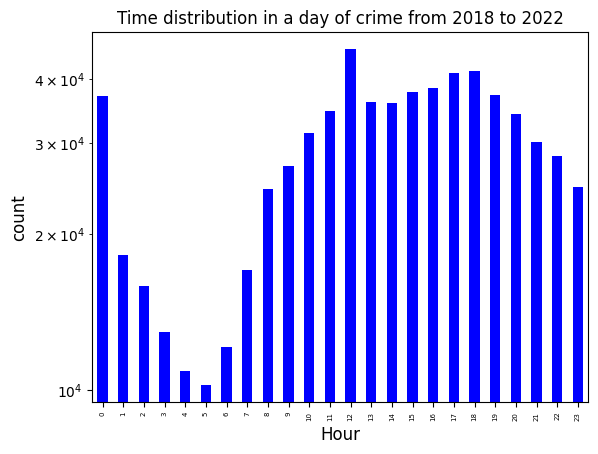

In [ ]:
#chart visualization
plt.figure()
ax = q4.plot(kind = 'bar', x = 'hour' , y = 'count', logy = True, color = 'blue', legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('Hour',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('Time distribution in a day of crime from 2018 to 2022')
display()

#### From the number of crime change in a day, we can find that the frequency of crime have three peaks in a day: 12AM, 12PM, and 18PM. The peak time in 12AM and 18PM can be explained by the huge footfall during that time. However, the phenomenon that sudden increase in the 12AM and sharply drop after that time is hard to explained.

In [ ]:
#check the hourly distribution for different types of crime
q5 = crime_df_new.groupby(['hour','Incident Category']).size().reset_index(name = 'count')
q5 = q5.sort_values(by='count', ascending=False)
q5.head(24)

hour    Incident Category  count
841     18        Larceny Theft  15632
887     19        Larceny Theft  14667
556     12        Larceny Theft  14128
794     17        Larceny Theft  13798
932     20        Larceny Theft  13176
510     11        Larceny Theft  12020
746     16        Larceny Theft  11591
698     15        Larceny Theft  11536
603     13        Larceny Theft  11491
650     14        Larceny Theft  11245
979     21        Larceny Theft  10208
463     10        Larceny Theft   9859
18       0        Larceny Theft   9570
1026    22        Larceny Theft   8337
417      9        Larceny Theft   7121
1073    23        Larceny Theft   6780
371      8        Larceny Theft   5897
65       1        Larceny Theft   4951
12       0                Fraud   4652
328      7        Larceny Theft   3591
111      2        Larceny Theft   3414
552     12                Fraud   3185
844     18   Malicious Mischief   2990
757     16  Other Miscellaneous   2905

In [ ]:
#check the hourly distribution for the 'Larceny Theft' category
q5_theft = q5[q5['Incident Category'].isin(['Larceny Theft'])]
q5_theft = q5_theft.sort_values(by = 'hour',ascending = True)
q5_theft.head()

hour Incident Category  count
18      0     Larceny Theft   9570
65      1     Larceny Theft   4951
111     2     Larceny Theft   3414
153     3     Larceny Theft   2746
198     4     Larceny Theft   2175

<Figure size 640x480 with 0 Axes>

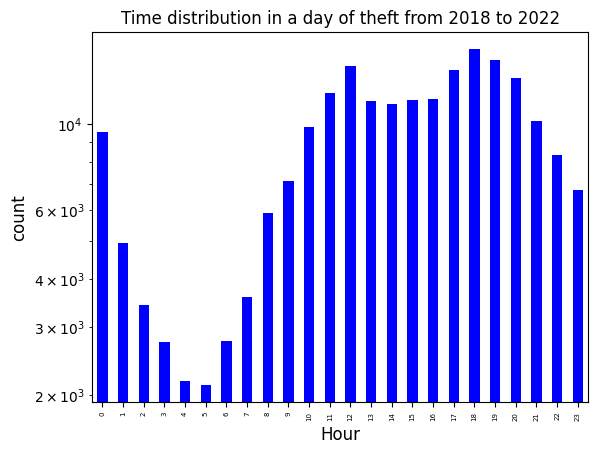

In [ ]:
#data visualization
plt.figure()
ax = q5_theft.plot(kind = 'bar', x = 'hour' , y = 'count', logy = True, color = 'blue', legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('Hour',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('Time distribution in a day of theft from 2018 to 2022')
display()

### The Resolution situation of crime in different categories

In [ ]:
#create dummy variables based on the 'resolution' column 
crime_df_new['Resolution'].unique()
crime_df_new['Result'] = np.where(crime_df_new['Resolution'] == 'Open or Active', 0, 1)
crime_df_new.info()

<ipython-input-24-1cd34a23cbb1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df_new['Result'] = np.where(crime_df_new['Resolution'] == 'Open or Active', 0, 1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682474 entries, 11 to 716671
Data columns (total 42 columns):
 #   Column                                                Non-Null Count   Dtype   
---  ------                                                --------------   -----   
 0   Incident Datetime                                     682474 non-null  object  
 1   Incident Date                                         682474 non-null  object  
 2   Incident Time                                         682474 non-null  object  
 3   Incident Year                                         682474 non-null  int64   
 4   Incident Day of Week                                  682474 non-null  object  
 5   Report Datetime                                       682474 non-null  object  
 6   Row ID                                                682474 non-null  int64   
 7   Incident ID                                           682474 non-null  int64   
 8   Incident Number                  

In [ ]:
# calculate the number of different kinds of crime that got resolution
q6 = crime_df_new.groupby(['Incident Category','Result']).size().reset_index(name = 'count')
q6 = q6.sort_values(by = 'Incident Category', ascending = True)
q6.head()
q6_solve = q6[q6.Result == 1]
q6_solve.head()
# merge the chart with number of crime to calculate the reolution rate
q6_merge = pd.merge(q6_solve, q1, on='Incident Category')
q6_merge['solve_rate'] = q6_merge.count_x/q6_merge.count_y
q6_merge.sort_values(by = 'solve_rate', ascending = True)

Incident Category  Result  count_x  count_y  \
19                               Lost Property       1       79    20831   
27                                       Other       1       67     5831   
36                                     Suicide       1        7      324   
37                                  Suspicious       1        3      102   
38                              Suspicious Occ       1      474    14652   
10                                 Fire Report       1       35     1052   
17                               Larceny Theft       1     7836   218642   
12                                       Fraud       1      955    22995   
22                              Missing Person       1      697    15462   
23                         Motor Vehicle Theft       1     1811    36698   
21                 Miscellaneous Investigation       1      409     7457   
5                              Courtesy Report       1      156     2101   
32                           Recovered Vehicle       1     2745    27881   
20                          Malicious Mischief       1     5109    48503   
31                                        Rape       1       19      172   
25                                Non-Criminal       1     4790    42605   
2                                     Burglary       1     4617    40225   
9                                 Embezzlement       1      124      927   
33                                     Robbery       1     2986    15998   
0                                        Arson       1      450     2052   
41                                   Vandalism       1      389     1534   
29                              Other Offenses       1     1654     6053   
11                  Forgery And Counterfeiting       1      684     2461   
6                           Disorderly Conduct       1     3325    11771   
1                                      Assault       1    12399    43600   
47                             Weapons Offense       1     1653     4893   
26    Offences Against The Family And Children       1     3352     9862   
43                           Vehicle Misplaced       1      104      297   
42                           Vehicle Impounded       1      180      472   
16      Human Trafficking, Commercial Sex Acts       1        9       22   
39                           Traffic Collision       1      739     1663   
28                         Other Miscellaneous       1    26580    49878   
14                                    Homicide       1       61      106   
34                                 Sex Offense       1      445      746   
15  Human Trafficking (A), Commercial Sex Acts       1       78      130   
13                                    Gambling       1       20       33   
24                        Motor Vehicle Theft?       1       47       74   
4                              Civil Sidewalks       1      638      888   
18                                 Liquor Laws       1       57       77   
35                             Stolen Property       1     2853     3563   
45                        Weapons Carrying Etc       1     3498     4081   
7                                 Drug Offense       1    15127    17606   
30                                Prostitution       1      811      941   
46                             Weapons Offence       1       19       21   
44                                     Warrant       1    18952    20713   
8                               Drug Violation       1      228      249   
40                    Traffic Violation Arrest       1     6413     6890   
3                                 Case Closure       1     2804     2929   

    solve_rate  
19    0.003792  
27    0.011490  
36    0.021605  
37    0.029412  
38    0.032351  
10    0.033270  
17    0.035839  
12    0.041531  
22    0.045078  
23    0.049349  
21    0.054848  
5     0.074250  
32    0.098454  
20    0.105334  
31    0.110465  
25    0.112428  
2     0.114779 

#### From the resolution rate of different kinds of crime, we can also find that the top number of crime category also have a low resolution rate. 'Larceny Theft' only has 3% resolution rate, while 'Marlicious Mischief' has 10% resolution rate. We can conclude that the crime that people are most likely to confront in the daily life still have a huge influence on city life. Therefore, it's necessary to perform a deeper analysis on which factor influence the conduct of crime.

# Combine crime data with social-ecnomic data and Zoning & Construction data

## clean the crime data

In [ ]:
#clean the crime dataset
crime_df_copy = crime_df_new.copy()
drop = ['Incident Datetime','Incident Date','Report Datetime','Row ID','Incident ID','Incident Number','CAD Number','Report Type Description','Filed Online','Incident Code','Incident Description',
        'CNN','Supervisor District','Central Market/Tenderloin Boundary Polygon - Updated','Civic Center Harm Reduction Project Boundary','HSOC Zones as of 2018-06-05','Invest In Neighborhoods (IIN) Areas',
        'Current Supervisor Districts','Current Police Districts']
crime_df_drop = crime_df_copy.drop(columns = drop)
crime_df_drop.info()

In [ ]:
#select the theft type data in 2020
crime_df_drop = crime_df_drop[crime_df_drop.year == 2020]
crime_df_drop = crime_df_drop[crime_df_drop['Incident Category'] == 'Larceny Theft']
crime_df_drop.reset_index()

In [ ]:
#get the geo boundary of San Francisco
sf_poly = osmnx.geocode_to_gdf('San Francisco, CA, USA')
sf_poly.plot()

In [ ]:
#convert to geopandas file
gpd_crime = gpd.GeoDataFrame(crime_df_drop, geometry = crime_df_drop['geometry'], crs={'init' :'epsg:4326'})
sf_poly.crs, gpd_crime.crs #.crs -- geodataframe

In [ ]:
#spatial join
gpd_crime_city = gpd.sjoin(gpd_crime,sf_poly,how='inner',op = 'intersects')
gpd_crime_city.tail(2)

In [ ]:
gpd_crime_city.info()

In [ ]:
#drop the useless data 
gpd_crime_city = gpd_crime_city.drop(['bbox_north','bbox_south','bbox_east','bbox_west','index_right'],axis = 1)

## Create the Physical Environment Data

### Street

In [ ]:
#get the street data of san francisco
sf_streets = osmnx.graph_from_place('San Francisco, California', network_type = 'drive')
nodes, edges = osmnx.graph_to_gdfs(sf_streets)

In [ ]:
nodes.head(1)

In [ ]:
edges.head(1)

In [ ]:
edges.plot()

In [ ]:
# brief information of road dataset
sf_road = edges.copy()
print(sf_road['highway'].value_counts())
print('Number of rows is ' + str(sf_road.shape[0]))
print('Number of columns is ' + str(sf_road.shape[1]))

In [ ]:
# Combining similar road types to reduce classification number
sf_road['highway'] = sf_road['highway'].str.replace('_link','')
sf_road['highway'] = np.where(sf_road['highway']=='trunk','secondary',sf_road['highway'])
sf_road['highway'] = np.where(sf_road['highway']=='living_street','residential',sf_road['highway'])
print(sf_road['highway'].value_counts())

In [ ]:
#based on road type to create sub-dataset
sf_highways = sf_road[sf_road.highway == 'motorway']
sf_pry = sf_road[sf_road.highway == 'primary']
sf_second = sf_road[sf_road.highway == 'secondary']
sf_resid = sf_road[sf_road.highway == 'residential']
sf_tertiary = sf_road[sf_road.highway == 'tertiary']

sf_highways.crs

In [ ]:
# convert to geopandas files and set function to calcualte the min distance from point to road
gpd_crime_city_utm = gpd_crime_city.to_crs({'init': 'epsg:32610'}).copy()   
highway_utm = sf_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = sf_pry.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = sf_second.to_crs({'init': 'epsg:32610'}).copy()
tertiary_utm = sf_tertiary.to_crs({'init': 'epsg:32610'}).copy()
residential_utm = sf_resid.to_crs({'init': 'epsg:32610'}).copy()
sf_road_utm = sf_road.to_crs({'init': 'epsg:32610'}).copy()

def distance_to_roadway(gps,roadway):
  dists = []
  for i in roadway.geometry:
    dists.append(i.distance(gps))
  return (np.min(dists))

In [ ]:
tqdm.pandas()
gpd_crime_city['Closest_highway'] = gpd_crime_city_utm['geometry'].progress_apply(distance_to_roadway,roadway = highway_utm)

In [ ]:
tqdm.pandas()
gpd_crime_city['Closest_primary'] = gpd_crime_city_utm['geometry'].progress_apply(distance_to_roadway,roadway = primary_utm)

In [ ]:
tqdm.pandas()
gpd_crime_city['Closest_secondary'] = gpd_crime_city_utm['geometry'].progress_apply(distance_to_roadway,roadway = secondary_utm)

In [ ]:
tqdm.pandas()
gpd_crime_city['Closest_tertiary'] = gpd_crime_city_utm['geometry'].progress_apply(distance_to_roadway,roadway = tertiary_utm)

In [ ]:
gpd_crime_city.head(2)

Incident Time  Incident Year Incident Day of Week Report Type Code  \
9676          02:00           2020               Friday               II   
13583         20:00           2020             Saturday               II   

      Incident Category    Incident Subcategory      Resolution  \
9676      Larceny Theft   Larceny Theft - Other  Open or Active   
13583     Larceny Theft  Larceny - From Vehicle  Open or Active   

                      Intersection Police District  Analysis Neighborhood  \
9676   BASS CT \ WHITNEY YOUNG CIR         Bayview  Bayview Hunters Point   
13583          CLAY ST \ LARKIN ST         Central           Russian Hill   

       ...        lat         lon  \
9676   ...  37.779026 -122.419906   
13583  ...  37.779026 -122.419906   

                                            display_name     class  \
9676   San Francisco, CAL Fire Northern Region, Calif...  boundary   
13583  San Francisco, CAL Fire Northern Region, Calif...  boundary   

                 type  importance Closest_highway  Closest_primary  \
9676   administrative    1.025131     1468.413426       534.950176   
13583  administrative    1.025131     2149.153684       390.024468   

       Closest_secondary  Closest_tertiary  
9676          535.680061        506.558042  
13583         285.145981         97.658841  

[2 rows x 36 columns]

In [ ]:
# based on the closest distance from point to each type of roads to ensure the road type where the crime point locate
def get_category(row):
    if row['Closest_highway'] < 10:
        return 'highway'
    elif row['Closest_primary'] < 10:
        return 'primary'
    elif row['Closest_secondary'] < 10:
        return 'secondary'
    elif row['Closest_tertiary'] < 10:
        return 'tertiary'
    else:
        return 'residential'
gpd_crime_city['Crime_Location'] = gpd_crime_city.apply(get_category, axis=1)

In [ ]:
gpd_crime_city.head(2)

Incident Time  Incident Year Incident Day of Week Report Type Code  \
9676          02:00           2020               Friday               II   
13583         20:00           2020             Saturday               II   

      Incident Category    Incident Subcategory      Resolution  \
9676      Larceny Theft   Larceny Theft - Other  Open or Active   
13583     Larceny Theft  Larceny - From Vehicle  Open or Active   

                      Intersection Police District  Analysis Neighborhood  \
9676   BASS CT \ WHITNEY YOUNG CIR         Bayview  Bayview Hunters Point   
13583          CLAY ST \ LARKIN ST         Central           Russian Hill   

       ...         lon                                       display_name  \
9676   ... -122.419906  San Francisco, CAL Fire Northern Region, Calif...   
13583  ... -122.419906  San Francisco, CAL Fire Northern Region, Calif...   

          class            type  importance  Closest_highway Closest_primary  \
9676   boundary  administrative    1.025131      1468.413426      534.950176   
13583  boundary  administrative    1.025131      2149.153684      390.024468   

       Closest_secondary  Closest_tertiary  Crime_Location  
9676          535.680061        506.558042     residential  
13583         285.145981         97.658841     residential  

[2 rows x 37 columns]

In [ ]:
gpd_crime_city.Crime_Location.value_counts()

residential    10518
secondary       8670
tertiary        6382
primary         2520
highway          123
Name: Crime_Location, dtype: int64

### Zoning

In [ ]:
#https://drive.google.com/file/d/1sremJO16LufbhJdXzSiAViXUmtJCieCN/view?usp=share_link
id = "1sremJO16LufbhJdXzSiAViXUmtJCieCN"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('SF_Zoning.csv')

In [ ]:
# load zoning data
zoning_df = pd.read_csv('SF_Zoning.csv')
zoning_df.head()

the_geom zoning_sim  \
0  MULTIPOLYGON (((-122.41533105377357 37.7723137...     RED-MX   
1  MULTIPOLYGON (((-122.38902391194917 37.7381094...        NCD   
2  MULTIPOLYGON (((-122.389357706792 37.738606785...      NCT-3   
3  MULTIPOLYGON (((-122.41533105377357 37.7723137...        RED   
4  MULTIPOLYGON (((-122.38155774047206 37.7381229...    PDR-1-B   

                                        districtname  \
0                          RESIDENTIAL ENCLAVE-MIXED   
1           BAYVIEW NEIGHBORHOOD COMMERCIAL DISTRICT   
2  MODERATE SCALE NEIGHBORHOOD COMMERCIAL TRANSIT...   
3                                RESIDENTIAL ENCLAVE   
4                        PDR LIGHT INDUSTRIAL BUFFER   

                                                 url          gen  \
0  https://codelibrary.amlegal.com/codes/san_fran...    Mixed Use   
1  https://codelibrary.amlegal.com/codes/san_fran...    Mixed Use   
2  https://codelibrary.amlegal.com/codes/san_fran...    Mixed Use   
3  https://codelibrary.amlegal.com/codes/san_fran...  Residential   
4  https://codelibrary.amlegal.com/codes/san_fran...   Industrial   

        zoning codesection  
0       RED-MX         847  
1  NCD-BAYVIEW         737  
2        NCT-3         752  
3          RED         813  
4      PDR-1-B       210.3

In [ ]:
from shapely.wkt import loads

In [ ]:
zoning_df['geometry'] = zoning_df['the_geom'].apply(loads)

# Create a GeoPandas DataFrame from the Pandas DataFrame
zoning_gdf = gpd.GeoDataFrame(zoning_df, crs='EPSG:4326', geometry='geometry')

In [ ]:
zoning_gdf.head()

In [ ]:
#drop irrelevant data
drop = ['zoning_sim','url','zoning','codesection']
zoning_new = zoning_gdf.drop(columns=drop)
zoning_new.head()

In [ ]:
#brief visualization 
fig, ax = plt.subplots(figsize=(6, 4))
zoning_new.to_crs(epsg=3857).plot(ax = ax,
                figsize=(12,12),
                markersize=40,
               color="black",
               edgecolor="white",
               alpha=0.8,
               marker="o"
            );
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [ ]:
#spatial join zoning data and crime data
gpd_crime_city_zone = gpd.sjoin(gpd_crime_city, zoning_new, op='within')
gpd_crime_city_zone.head(2)

### Building

In [ ]:
#https://drive.google.com/file/d/1-7NryT-DamfZnKO7mU9ZqZsISg5TInsC/view?usp=share_link
id = "1-7NryT-DamfZnKO7mU9ZqZsISg5TInsC"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('sf_building.csv')

In [ ]:
#load building footprints data
building_df = pd.read_csv('sf_building.csv')
building_df.head()

sf16_bldgid  area_id         mblr             p2010_name  \
0  201006.000000        1    SF4570025      SanfranF_4606.flt   
1  201006.000000        2  SM005050270     SanfranI_09417.flt   
2  201006.000000        3    SF3794028  Sanfran_Orig_1330.flt   
3  201006.003228    32278  SM004154340      SanfranP_3364.flt   
4  201006.000000        4    SF7295021                    NaN   

   p2010_zminn88ft  p2010_zmaxn88ft  gnd_cells50cm  gnd_mincm  gnd_maxcm  \
0          16.3249          66.2671         178250        507        704   
1          81.7802         214.1874         144111       2515       3419   
2          12.5027         102.5737         115295        164        507   
3         342.5260         381.3803            708      10454      10532   
4              NaN              NaN         107634       4346       5185   

   gnd_rangecm  ...  hgt_majoritycm  hgt_minoritycm  hgt_mediancm  gnd_min_m  \
0          197  ...             813             349           850       5.07   
1          904  ...             737              11           735      25.15   
2          343  ...             734             -86          1157       1.64   
3           78  ...             521             140           456     104.54   
4          839  ...            1078              16          1153      43.46   

   median_1st_m  hgt_median_m  gnd1st_delta  peak_1st_m  \
0         14.16          8.50          9.09       23.85   
1         39.25          7.35         14.10       66.94   
2         15.29         11.57         13.65       59.18   
3        109.39          4.56          4.85      111.79   
4         61.58         11.53         18.12       69.72   

                                 globalid  \
0  {CF7EF595-68E6-4950-B361-CC82D77383A0}   
1  {806F8EDB-7B25-4054-898E-6F2CF65D072E}   
2  {F0F234CF-3F0B-439D-B59A-8899C2135F23}   
3  {C321EB73-7E6E-49B5-822B-3E7DD3A7F0AD}   
4  {C52C089C-B0A6-4716-8358-C568A65861DC}   

                                               shape  
0  MULTIPOLYGON (((-122.37950387699999 37.7397994...  
1  MULTIPOLYGON (((-122.41894297800002 37.7076482...  
2  MULTIPOLYGON (((-122.38881976200003 37.7792352...  
3  MULTIPOLYGON (((-122.45552821000001 37.7074943...  
4  MULTIPOLYGON (((-122.47734992300002 37.7289024...  

[5 rows x 43 columns]

In [ ]:
##keep the geometry and height data
building_df = building_df[['peak_1st_m','shape']]
building_df.head(2)

In [ ]:
building_df['geometry'] = building_df['shape'].apply(loads)
# Create a GeoPandas DataFrame from the Pandas DataFrame
building_gdf = gpd.GeoDataFrame(building_df, crs='EPSG:4326', geometry='geometry')

In [ ]:
building_gdf.head(2)

In [ ]:
# Calculate the area of each building
building_gdf['area'] = building_gdf['geometry'].area
building_gdf.head(2)

In [ ]:
# turan the form of data from polygon to point for find nearest point
point_gdf = building_gdf.copy()
point_gdf["geometry"] = building_gdf.centroid
point_gdf.head(2)

In [ ]:
gpd_crime_city_zone = gpd_crime_city_zone.rename(columns={'index_left': 'left'})
gpd_crime_city_zone = gpd_crime_city_zone.rename(columns={'index_right': 'right'})

In [ ]:
gpd_crime_city_zone.head(2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#save_path = '/content/drive/MyDrive/Colab Notebooks/data/gpd_crime_city_zone.csv'
#df.to_csv(save_path, index=False)

Mounted at /content/drive


In [ ]:
#https://drive.google.com/file/d/1WkxWvKEsSpq50x-BEasGqmsgu6pi91_m/view?usp=share_link
id = "1WkxWvKEsSpq50x-BEasGqmsgu6pi91_m"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('gpd_crime_city_zone.csv')

In [ ]:
gpd_crime_city_zone = pd.read_csv('gpd_crime_city_zone.csv')
gpd_crime_city_zone.head()

Incident Time  Incident Year Incident Day of Week Report Type Code  \
0         02:00           2020               Friday               II   
1         13:59           2020               Sunday               VI   
2         16:28           2020               Friday               II   
3         18:00           2020              Tuesday               II   
4         21:00           2020               Sunday               VI   

  Incident Category   Incident Subcategory      Resolution  \
0     Larceny Theft  Larceny Theft - Other  Open or Active   
1     Larceny Theft     Theft From Vehicle  Open or Active   
2     Larceny Theft  Larceny Theft - Other  Open or Active   
3     Larceny Theft   Larceny - Auto Parts  Open or Active   
4     Larceny Theft     Theft From Vehicle  Open or Active   

                                  Intersection Police District  \
0                  BASS CT \ WHITNEY YOUNG CIR         Bayview   
1  WHITNEY YOUNG CIR \ CASHMERE ST \ DEDMAN CT         Bayview   
2                    LA SALLE AVE \ OSCEOLA LN         Bayview   
3                       INGALLS ST \ HARBOR RD         Bayview   
4                     CASHMERE ST \ HUDSON AVE         Bayview   

   Analysis Neighborhood  ...  Closest_primary  Closest_secondary  \
0  Bayview Hunters Point  ...       534.950176         535.680061   
1  Bayview Hunters Point  ...       364.965970         433.206386   
2  Bayview Hunters Point  ...       833.743266         461.886008   
3  Bayview Hunters Point  ...       951.461748         255.279620   
4  Bayview Hunters Point  ...       582.547890         387.780374   

   Closest_tertiary Crime_Location  right  \
0        506.558042    residential    815   
1        203.201740    residential    815   
2        835.429639    residential    815   
3        825.220932    residential    815   
4        420.026310    residential    815   

                                            the_geom  \
0  MULTIPOLYGON (((-122.38222192626027 37.7365910...   
1  MULTIPOLYGON (((-122.38222192626027 37.7365910...   
2  MULTIPOLYGON (((-122.38222192626027 37.7365910...   
3  MULTIPOLYGON (((-122.38222192626027 37.7365910...   
4  MULTIPOLYGON (((-122.38222192626027 37.7365910...   

                     districtname          gen  \
0  RESIDENTIAL- HOUSE, TWO FAMILY  Residential   
1  RESIDENTIAL- HOUSE, TWO FAMILY  Residential   
2  RESIDENTIAL- HOUSE, TWO FAMILY  Residential   
3  RESIDENTIAL- HOUSE, TWO FAMILY  Residential   
4  RESIDENTIAL- HOUSE, TWO FAMILY  Residential   

                                           buffer_5m  \
0  POLYGON ((-117.38469170531177 37.7337597458953...   
1  POLYGON ((-117.38571301129124 37.7366011278019...   
2  POLYGON ((-117.3819485575142 37.73152913469796...   
3  POLYGON ((-117.3799317268322 37.73338073279184...   
4  POLYGON ((-117.38342544658872 37.7358032525956...   

                                              buffer  
0  POLYGON ((-117.38469170531177 37.7337597458953...  
1  POLYGON ((-117.38571301129124 37.7366011278019...  
2  POLYGON ((-117.3819485575142 37.73152913469796...  
3  POLYGON ((-117.3799317268322 37.73338073279184...  
4  POLYGON ((-117.38342544658872 37.7358032525956...  

[5 rows x 43 columns]

In [ ]:
gpd_crime_city_zone = gpd.GeoDataFrame(gpd_crime_city_zone, geometry=gpd.points_from_xy(gpd_crime_city_zone.Longitude, gpd_crime_city_zone.Latitude), crs={'init' :'epsg:4326'})
gpd_crime_city_zone.info()

In [ ]:
from scipy.spatial import cKDTree

In [ ]:
pd_crime_city_zone = np.array(list(gpd_crime_city_zone.geometry.apply(lambda pt: (pt.x, pt.y))))
point_df = np.array(list(point_gdf.geometry.apply(lambda pt: (pt.x, pt.y))))

# Build cKDTree from crime points
tree = cKDTree(point_df)

# Query tree for nearest crime to each Boston point
dist, idx = tree.query(pd_crime_city_zone, k=1)

# Add nearest crime column to boston GeoDataFrame
gpd_crime_city_zone['builidng_nn1'] = point_gdf.loc[idx, 'peak_1st_m'].values

In [ ]:
drop = ['buffer_5m','buffer','right']
gpd_crime_city_zone = gpd_crime_city_zone.drop(columns=drop)

In [ ]:
val_dict = {'highway': 24, 'primary': 20, 'secondary': 12, 'tertiary': 8, 'residential': 6}
gpd_crime_city_zone['road_width'] = gpd_crime_city_zone['Crime_Location'].map(val_dict)

In [ ]:
gpd_crime_city_zone['rate_BS'] = gpd_crime_city_zone['builidng_nn1']/gpd_crime_city_zone['road_width']

### Census tract

#### load basic census tract boundary

In [ ]:
#https://drive.google.com/file/d/1DbA90nYecBQnwRkcqUAAP8vT7OQP9MWz/view?usp=share_link
id = "1DbA90nYecBQnwRkcqUAAP8vT7OQP9MWz"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('sf_centra.csv')

In [ ]:
ct_df = pd.read_csv('sf_centra.csv')
ct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    176 non-null    object 
 1   OBJECTID    176 non-null    int64  
 2   FIPSSTCO    176 non-null    int64  
 3   TRT2000     176 non-null    int64  
 4   STFID       176 non-null    int64  
 5   TRACTID     176 non-null    float64
 6   STATE       176 non-null    int64  
 7   COUNTY      176 non-null    int64  
 8   TRACT       176 non-null    int64  
 9   POP2000     176 non-null    int64  
 10  WHITE       176 non-null    int64  
 11  BLACK       176 non-null    int64  
 12  AMERI_ES    176 non-null    int64  
 13  ASIAN       176 non-null    int64  
 14  HAWN_PI     176 non-null    int64  
 15  OTHER       176 non-null    int64  
 16  MULT_RACE   176 non-null    int64  
 17  HISPANIC    176 non-null    int64  
 18  MALES       176 non-null    int64  
 19  FEMALES     176 non-null    i

In [ ]:
ct_df['TRACTID'] = ct_df['TRACTID'].astype('object')

#### load social-economic data based on the census tract

In [ ]:
import censusdata
from census import Census
from us import states

In [ ]:
# Define the Census API key
censusdata.censuskey = "93db71b5bb2f994846b61d1cb53de6b204ed41b8"
c = Census("93db71b5bb2f994846b61d1cb53de6b204ed41b8")
year = 2020
state_fips = '06'  # California
county_fips = '075'  # San Francisco County

#	B07010_004 -- Estimate!!Total:!!With income:!!$1 to $9,999 or loss -- poverty indicator
# B06009_002 -- Estimate!!Total:!!Less than high school graduate
# B09010_002 -- Estimate!!Total:!!Living in household with Supplemental Security Income (SSI), cash public assistance income, or Food Stamps/SNAP in the past 12 months:
# B27011_008 -- Estimate!!Total:!!In labor force:!!Unemployed:
# B11013_002 -- Estimate!!Total:!!Married-couple subfamily
# B11013_005 -- Estimate!!Total:!!Mother-child subfamily
# B11013_006 -- Estimate!!Total:!!Father-child subfamily
va_census = c.acs5.state_county_tract(fields = ('NAME','B07010_004E','B06009_002E', 'B09010_002E', 'B27011_008E','B11014_005E','B11014_006E','B11014_009E'),
                                      state_fips = '06',
                                      county_fips = '075',
                                      tract = "*",
                                      year = 2020)

In [ ]:
sfp_df = pd.DataFrame(va_census)
sfp_df.head(2)

In [ ]:
sfp_df['tract'] = sfp_df['NAME'].str.extract(r'Census Tract (\d+\.\d+)', expand=False)

In [ ]:
sfp_df.head(2)

In [ ]:
sfp_df = sfp_df.rename(columns={'B07010_004E': 'low_income', 'B06009_002E':'low_education','B09010_002E':'fd_secure','B27011_008E':'unemploy','B11014_005E':'couple_fa',
                                'B11014_006E':'ma-child','B11014_009E':'fa-child'})
sfp_df.head(2)

In [ ]:
sfp_df = sfp_df.rename(columns={'tract': 'TRACTID'})
sfp_df.head(2)

In [ ]:
socieco_df = pd.merge(ct_df, sfp_df, on='TRACTID',how='left')

In [ ]:
ct_df['geometry'] = ct_df['the_geom'].apply(loads)
# Create a GeoPandas DataFrame from the Pandas DataFrame
ct_gdf = gpd.GeoDataFrame(ct_df, crs='EPSG:4326', geometry='geometry')

# Data Analysis and Visualization

In [ ]:
# the data that crime with place's social-economic type
gpd_crime_fnl = gpd.sjoin(gpd_crime_city_zone, ct_gdf, op='within')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
gpd_crime_fnl.head(2)

Incident Time  Incident Year Incident Day of Week Report Type Code  \
0         02:00           2020               Friday               II   
1         13:59           2020               Sunday               VI   

  Incident Category   Incident Subcategory      Resolution  \
0     Larceny Theft  Larceny Theft - Other  Open or Active   
1     Larceny Theft     Theft From Vehicle  Open or Active   

                                  Intersection Police District  \
0                  BASS CT \ WHITNEY YOUNG CIR         Bayview   
1  WHITNEY YOUNG CIR \ CASHMERE ST \ DEDMAN CT         Bayview   

   Analysis Neighborhood  Supervisor District 2012   Latitude   Longitude  \
0  Bayview Hunters Point                      10.0  37.733760 -122.384692   
1  Bayview Hunters Point                      10.0  37.736601 -122.385713   

                                           Point  Neighborhoods  \
0  POINT (-122.38469170531177 37.73375974589532)           86.0   
1   POINT (-122.38571301129124 37.7366011278019)           86.0   

   ESNCAG - Boundary File                     geometry  year  month  day  \
0                     NaN  POINT (-122.38469 37.73376)  2020      4   10   
1                     NaN  POINT (-122.38571 37.73660)  2020      2    9   

   hour  minute  Result   place_id  osm_type  osm_id        lat         lon  \
0     2       0       0  297983890  relation  111968  37.779026 -122.419906   
1    13      59       0  297983890  relation  111968  37.779026 -122.419906   

                                        display_name     class  \
0  San Francisco, CAL Fire Northern Region, Calif...  boundary   
1  San Francisco, CAL Fire Northern Region, Calif...  boundary   

             type  importance  Closest_highway  Closest_primary  \
0  administrative    1.025131      1468.413426       534.950176   
1  administrative    1.025131      1194.113022       364.965970   

   Closest_secondary  Closest_tertiary Crime_Location  \
0         535.680061        506.558042    residential   
1         433.206386        203.201740    residential   

                                       the_geom_left  \
0  MULTIPOLYGON (((-122.38222192626027 37.7365910...   
1  MULTIPOLYGON (((-122.38222192626027 37.7365910...   

                     districtname          gen  builidng_nn1  road_width  \
0  RESIDENTIAL- HOUSE, TWO FAMILY  Residential         18.58           6   
1  RESIDENTIAL- HOUSE, TWO FAMILY  Residential         18.58           6   

    rate_BS  index_right                                     the_geom_right  \
0  3.096667           42  MULTIPOLYGON (((-122.38155725680222 37.7381228...   
1  3.096667           42  MULTIPOLYGON (((-122.38155725680222 37.7381228...   

   OBJECTID  FIPSSTCO  TRT2000       STFID TRACTID  STATE  COUNTY  TRACT  \
0       239      6075    23102  6075023102  231.02      6      75  23102   
1       239      6075    23102  6075023102  231.02      6      75  23102   

   POP2000  WHITE  BLACK  AMERI_ES  ASIAN  HAWN_PI  OTHER  MULT_RACE  \
0     3600    230   2625         7    421       29    148        140   
1     3600    230   2625         7    421       29    148        140   

   HISPANIC  MALES  FEMALES  AGE_UNDER5  AGE_5_17  AGE_18_21  AGE_22_29  \
0       321   1637     1963         262       957        180        340   
1       321   1637     1963         262       957        180        340   

   AGE_30_39  AGE_40_49  AGE_50_64  AGE_65_UP  MED_AGE  MED_AGE_M  MED_AGE_F  \
0        559        504        482        316     31.0       26.7       34.5   
1        559        504        482        316     31.0       26.7       34.5   

   HOUSEHOLDS  AVE_HH_SZ  HSEHLD_1_M  HSEHLD_1_F  MARHH_CHD  MARHH_NO_C  \
0        1259       2.86         111         203        171         117   
1        1259       2.86         111         203        171         117   

   MHH_CHILD  FHH_CHILD  FAMILIES  AVE_FAM_SZ  HSE_UNITS  URBAN  RURAL  \
0         24        307       876         3.4       1289      0      0   
1 

In [ ]:
gpd_crime_fnl['gen'].value_counts()

In [ ]:
def get_category(row):
    if row['gen'] == 'Residential':
        return 1
    elif row['gen'] == 'Mixed Use':
        return 2
    elif row['gen'] == 'Commercial':
        return 3
    elif row['gen'] == 'Public':
        return 4
    else:
        return 5
gpd_crime_fnl['ztype'] = gpd_crime_fnl.apply(get_category, axis=1)

In [ ]:
gpd_crime_fnl['Crime_Location'].value_counts()

In [ ]:
def get_category(row):
    if row['Crime_Location'] == 'residential':
        return 1
    elif row['Crime_Location'] == 'secondary':
        return 2
    elif row['Crime_Location'] == 'tertiary':
        return 3
    elif row['Crime_Location'] == 'primary':
        return 4
    else:
        return 5
gpd_crime_fnl['rtype'] = gpd_crime_fnl.apply(get_category, axis=1)

In [ ]:
# Numerical Features
numerical = ['Result','Neighborhoods', 'Supervisor District 2012', 'month', 'day', 'hour', 'minute', 'Closest_highway', 'Closest_primary', 'Closest_secondary', 'Closest_tertiary', 
              'road_width', 'rate_BS', 'POP2000','Longitude', 'Latitude', 'MALES', 'FEMALES','AGE_UNDER5','AGE_5_17','AGE_18_21','AGE_22_29','AGE_30_39','AGE_40_49',
             'AGE_50_64','AGE_65_UP','MED_AGE','MED_AGE_M','MED_AGE_F','HOUSEHOLDS','AVE_HH_SZ','HSEHLD_1_M','HSEHLD_1_F','MARHH_CHD','MARHH_NO_C','MHH_CHILD','FHH_CHILD','FAMILIES',
             'AVE_FAM_SZ','HSE_UNITS','VACANT','OWNER_OCC','RENTER_OCC','rtype','ztype']

# Categorical Features 
categorical = ['Incident Day of Week', 'Report Type Code', 'Crime_Location','gen']

In [ ]:
df_vs = gpd_crime_fnl.copy()

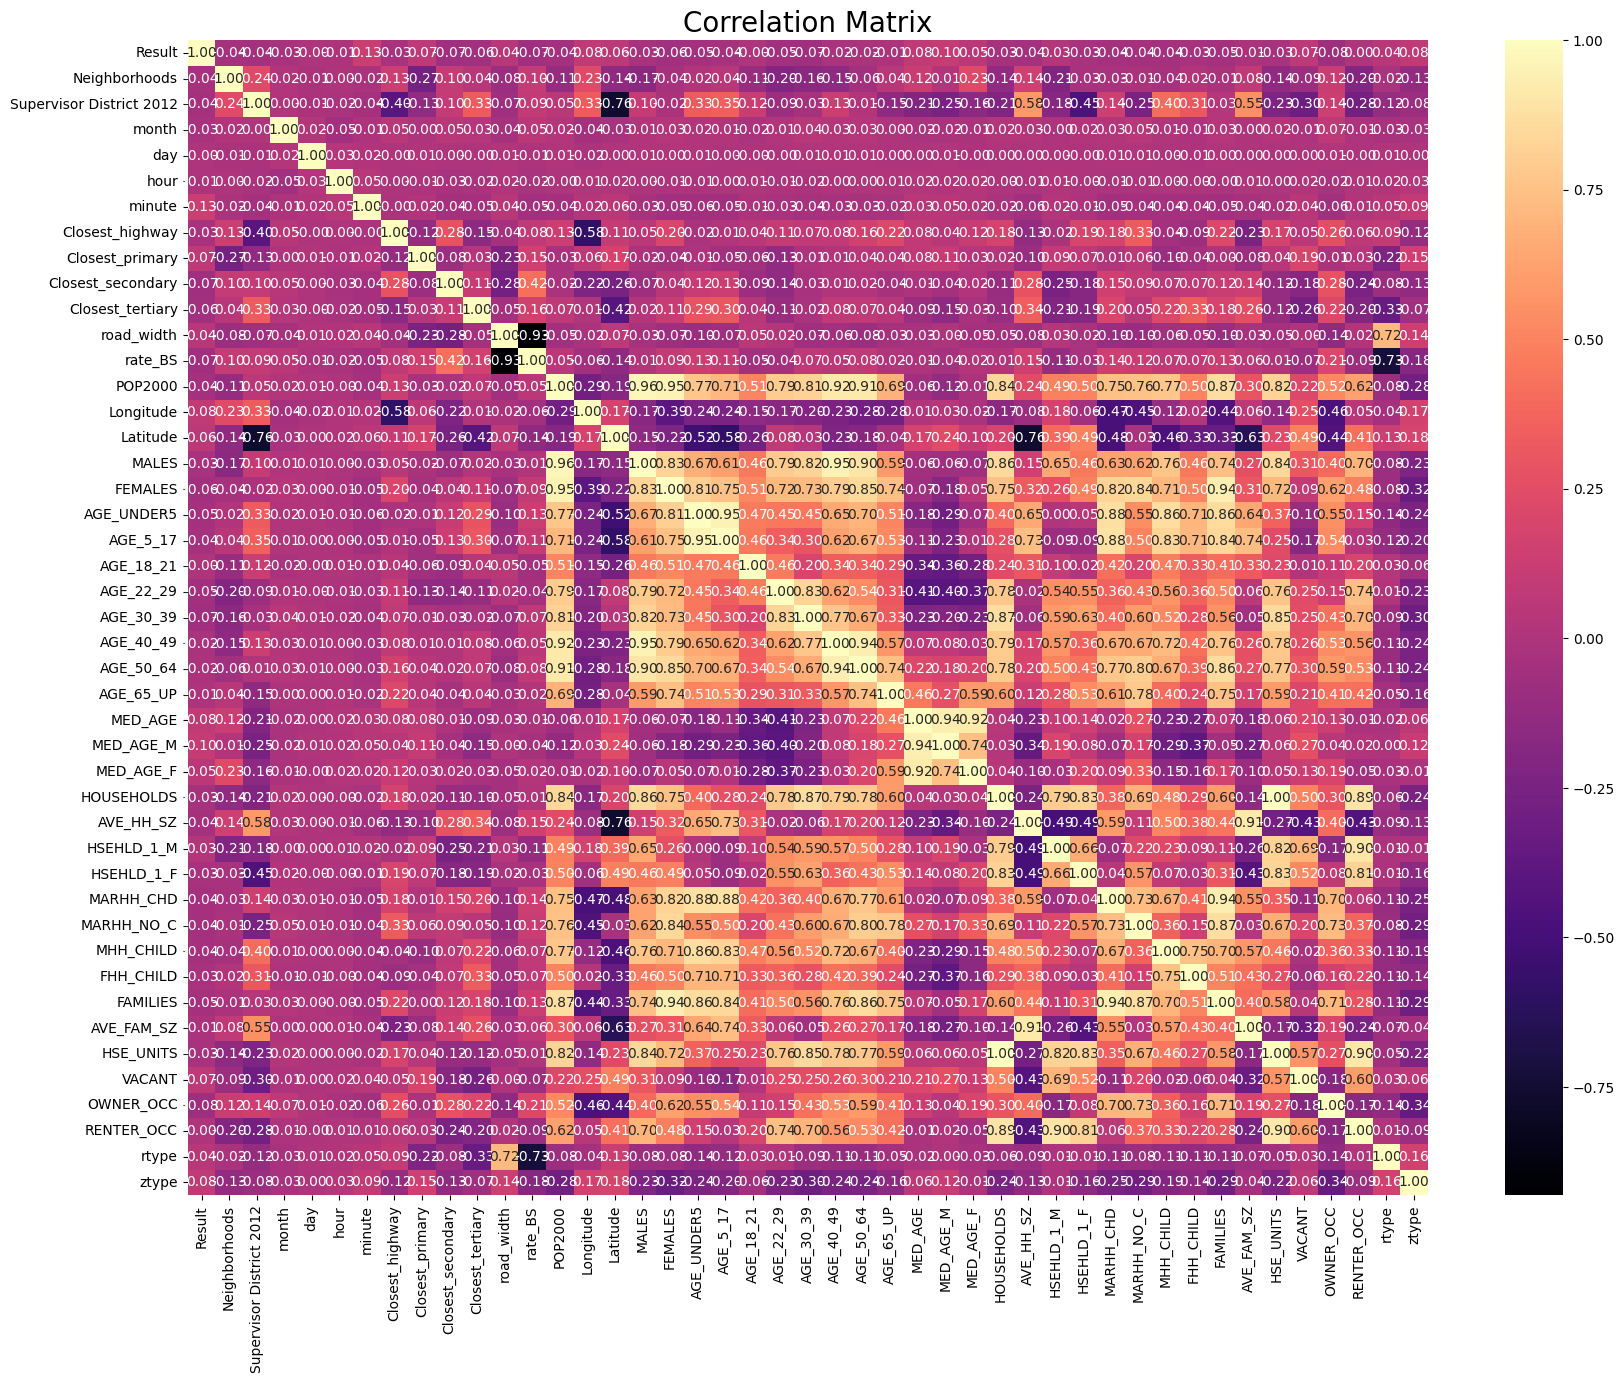

In [ ]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_vs[numerical].corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
Corr = pd.DataFrame(df_vs[numerical].corr()['Result'].sort_values(ascending = False))
Corr = Corr.iloc[1:,:]
Corr.columns = ['Targer Correlation']
Corr

Targer Correlation
minute                              0.125436
MED_AGE_M                           0.103229
MED_AGE                             0.082230
Longitude                           0.082165
ztype                               0.080871
Closest_primary                     0.071255
VACANT                              0.070051
Latitude                            0.059627
MED_AGE_F                           0.049638
road_width                          0.039319
rtype                               0.038533
HSEHLD_1_M                          0.025309
RENTER_OCC                          0.001603
day                                -0.000748
AGE_18_21                          -0.001998
hour                               -0.005705
AGE_65_UP                          -0.006762
AVE_FAM_SZ                         -0.012245
AGE_50_64                          -0.017518
AGE_40_49                          -0.024185
HSE_UNITS                          -0.026224
month                              -0.026534
Closest_highway                    -0.026694
MALES                              -0.027852
HSEHLD_1_F                         -0.028811
FHH_CHILD                          -0.031284
HOUSEHOLDS                         -0.034578
AGE_5_17                           -0.037363
Neighborhoods                      -0.037629
MHH_CHILD                          -0.041164
MARHH_NO_C                         -0.041853
MARHH_CHD                          -0.042327
Supervisor District 2012           -0.042750
AVE_HH_SZ                          -0.044648
POP2000                            -0.044909
AGE_UNDER5                         -0.047650
FAMILIES                           -0.047962
AGE_22_29                          -0.054750
Closest_tertiary                   -0.056600
FEMALES                            -0.060230
rate_BS                            -0.065186
AGE_30_39                          -0.068832
Closest_secondary                  -0.070957
OWNER_OCC                          -0.078604

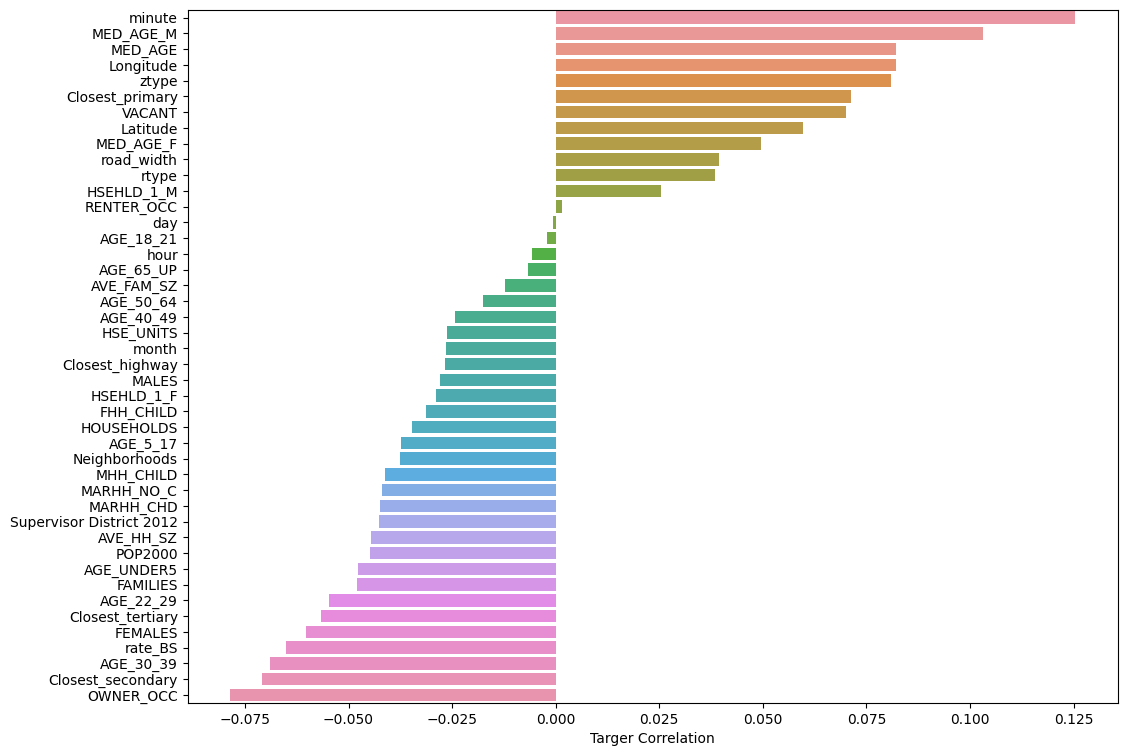

In [ ]:
g0 = sns.barplot(x="Targer Correlation", y=Corr.index, data=Corr)
g0.figure.set_size_inches(12, 9)

In [ ]:
gpd_crime_vs = gpd_crime_fnl.copy()

Text(0, 0.5, 'Latitude')

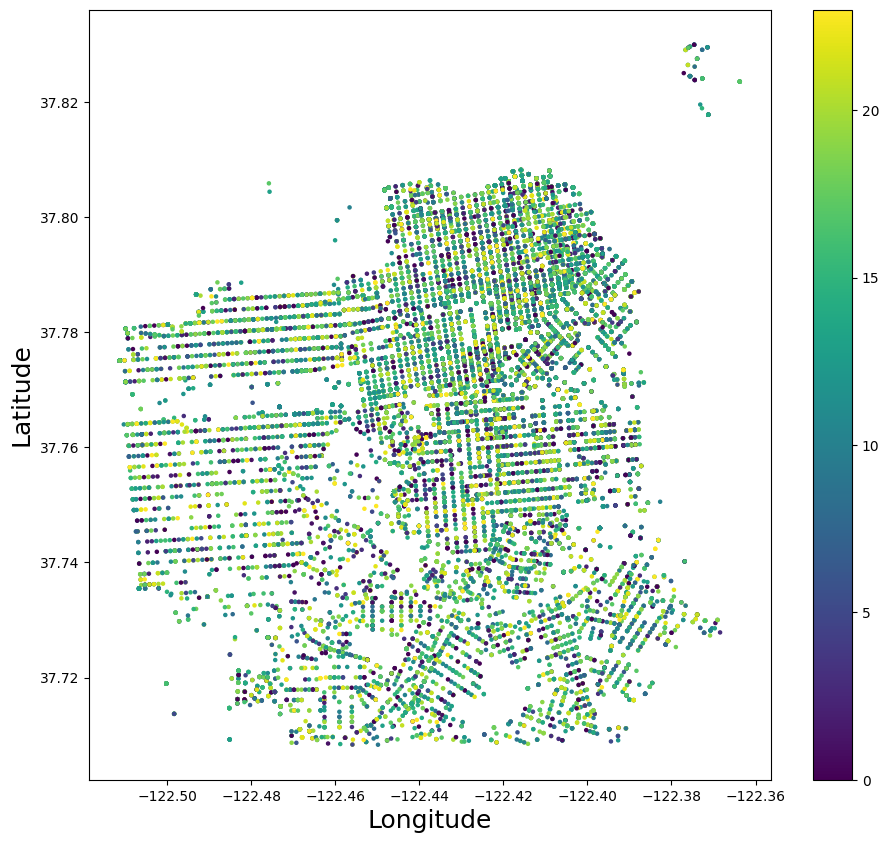

In [ ]:
plt.figure(figsize = (11, 10))
plt.scatter(gpd_crime_vs.Longitude, gpd_crime_vs.Latitude, s=5, c = gpd_crime_vs.hour)
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

Text(0, 0.5, 'Latitude')

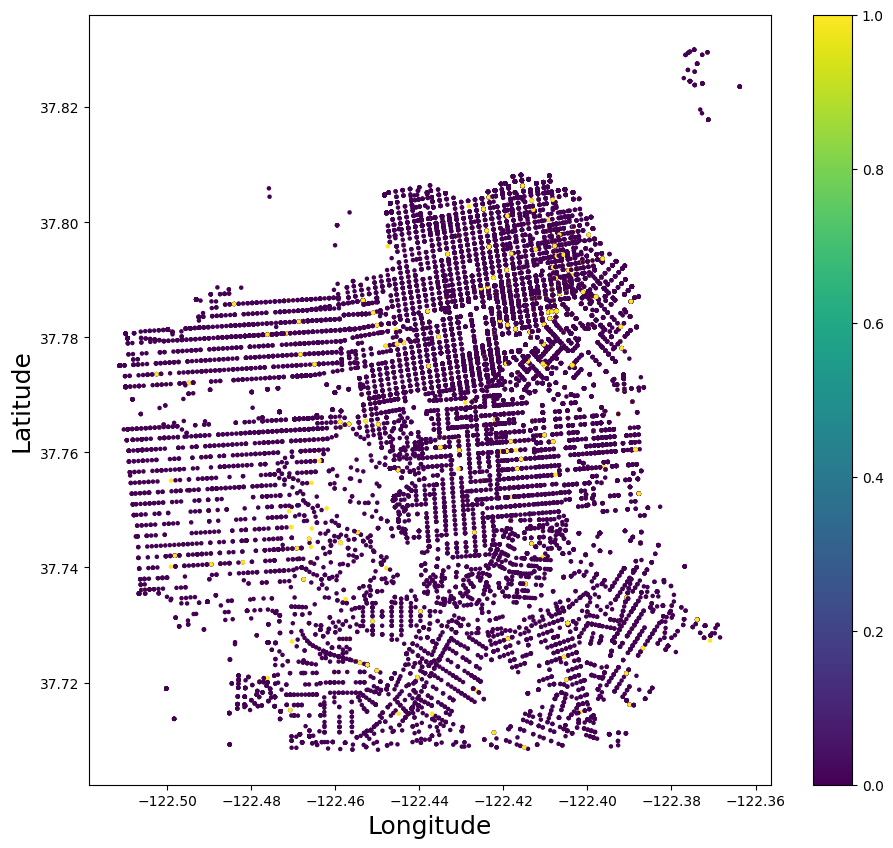

In [ ]:
plt.figure(figsize = (11, 10))
plt.scatter(gpd_crime_vs.Longitude, gpd_crime_vs.Latitude, s=5, c = gpd_crime_vs.Result)
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

<Axes: xlabel='Result', ylabel='count'>

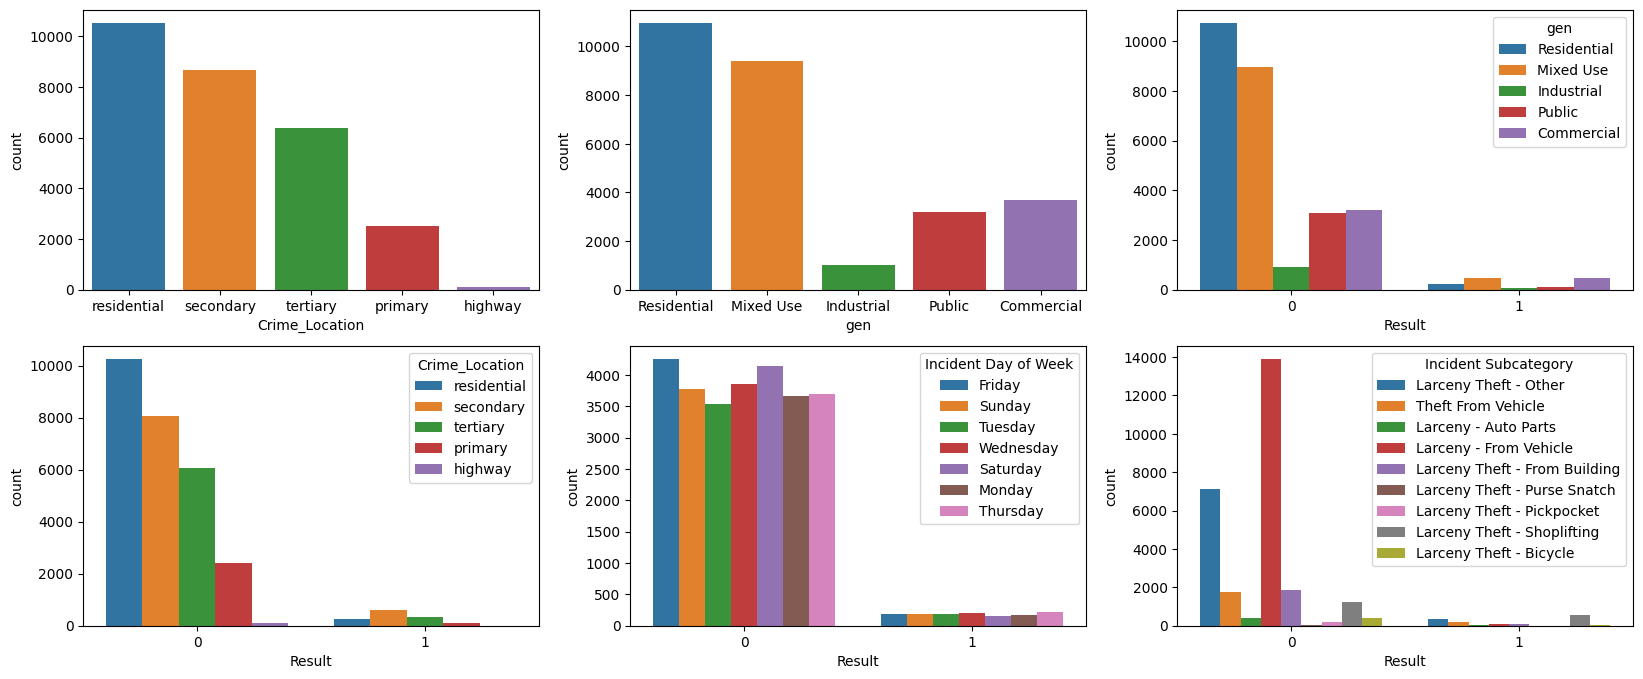

In [ ]:
_,axss = plt.subplots(2,3, figsize = [20,8])
sns.countplot(x = 'Crime_Location', data = gpd_crime_vs,ax=axss[0][0])
sns.countplot(x = 'gen', data = gpd_crime_vs,ax=axss[0][1])
sns.countplot(x = 'Result', hue = gpd_crime_vs['gen'], data = gpd_crime_vs,ax=axss[0][2])
sns.countplot(x = 'Result', hue = gpd_crime_vs['Crime_Location'], data = gpd_crime_vs,ax=axss[1][0])
sns.countplot(x = 'Result', hue = gpd_crime_vs['Incident Day of Week'], data = gpd_crime_vs,ax=axss[1][1])
sns.countplot(x = 'Result', hue = gpd_crime_vs['Incident Subcategory'], data = gpd_crime_vs,ax=axss[1][2])

<Axes: xlabel='Result', ylabel='VACANT'>

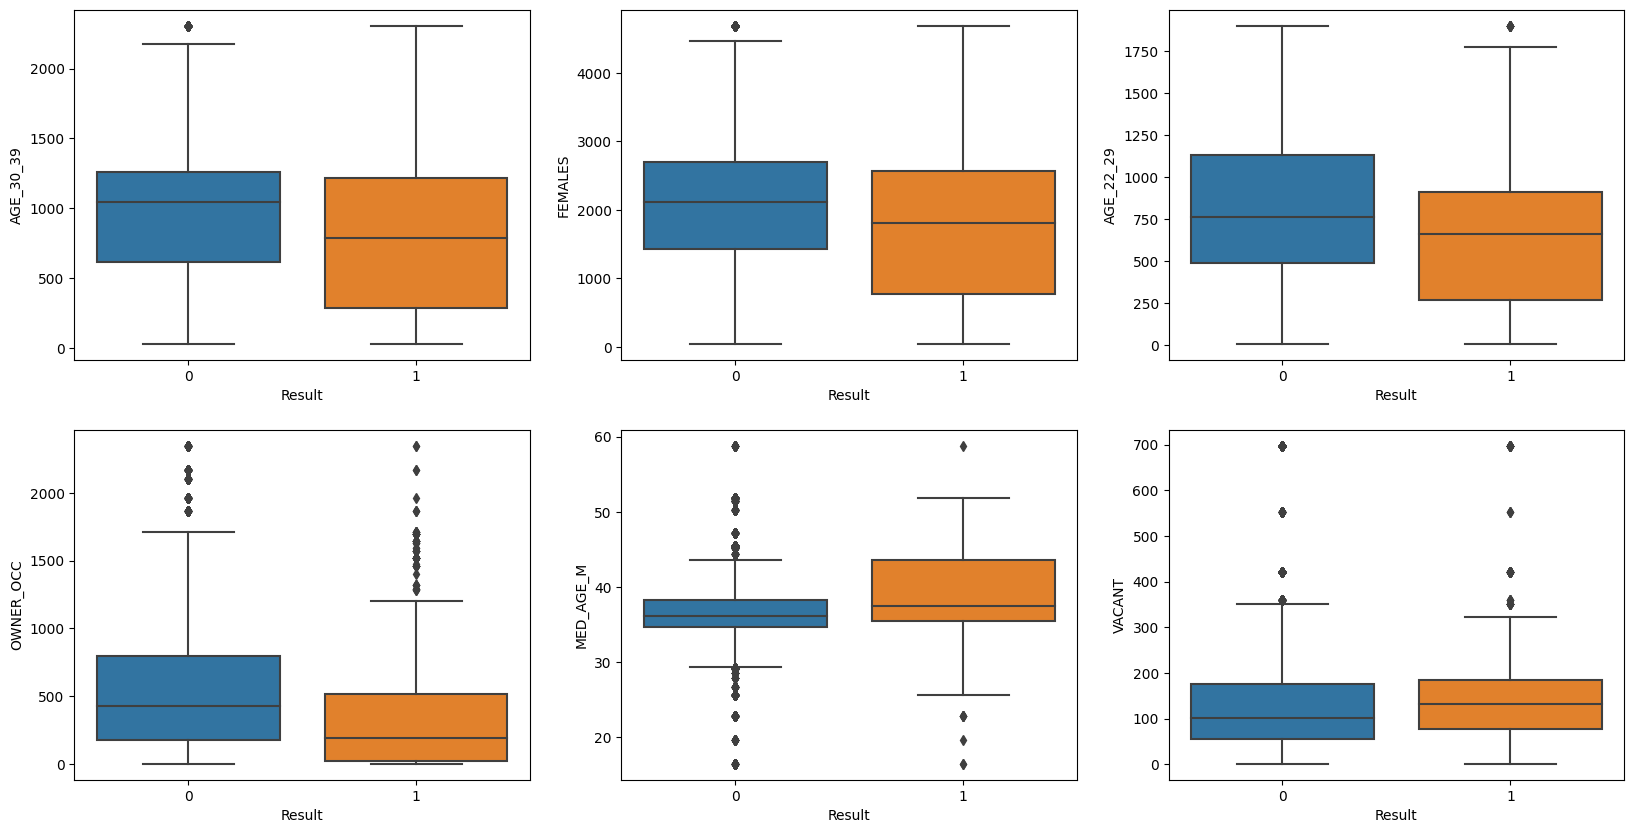

In [ ]:
_,axss = plt.subplots(2,3, figsize = [20,10])
sns.boxplot(x='Result',y='AGE_30_39',data=gpd_crime_vs,ax=axss[0][0])
sns.boxplot(x='Result',y='FEMALES',data=gpd_crime_vs,ax=axss[0][1])
sns.boxplot(x='Result',y='AGE_22_29',data=gpd_crime_vs,ax=axss[0][2])
sns.boxplot(x='Result',y='OWNER_OCC',data=gpd_crime_vs,ax=axss[1][0])
sns.boxplot(x='Result',y='MED_AGE_M',data=gpd_crime_vs,ax=axss[1][1])
sns.boxplot(x='Result',y='VACANT',data=gpd_crime_vs,ax=axss[1][2])

<Axes: xlabel='Result', ylabel='road_width'>

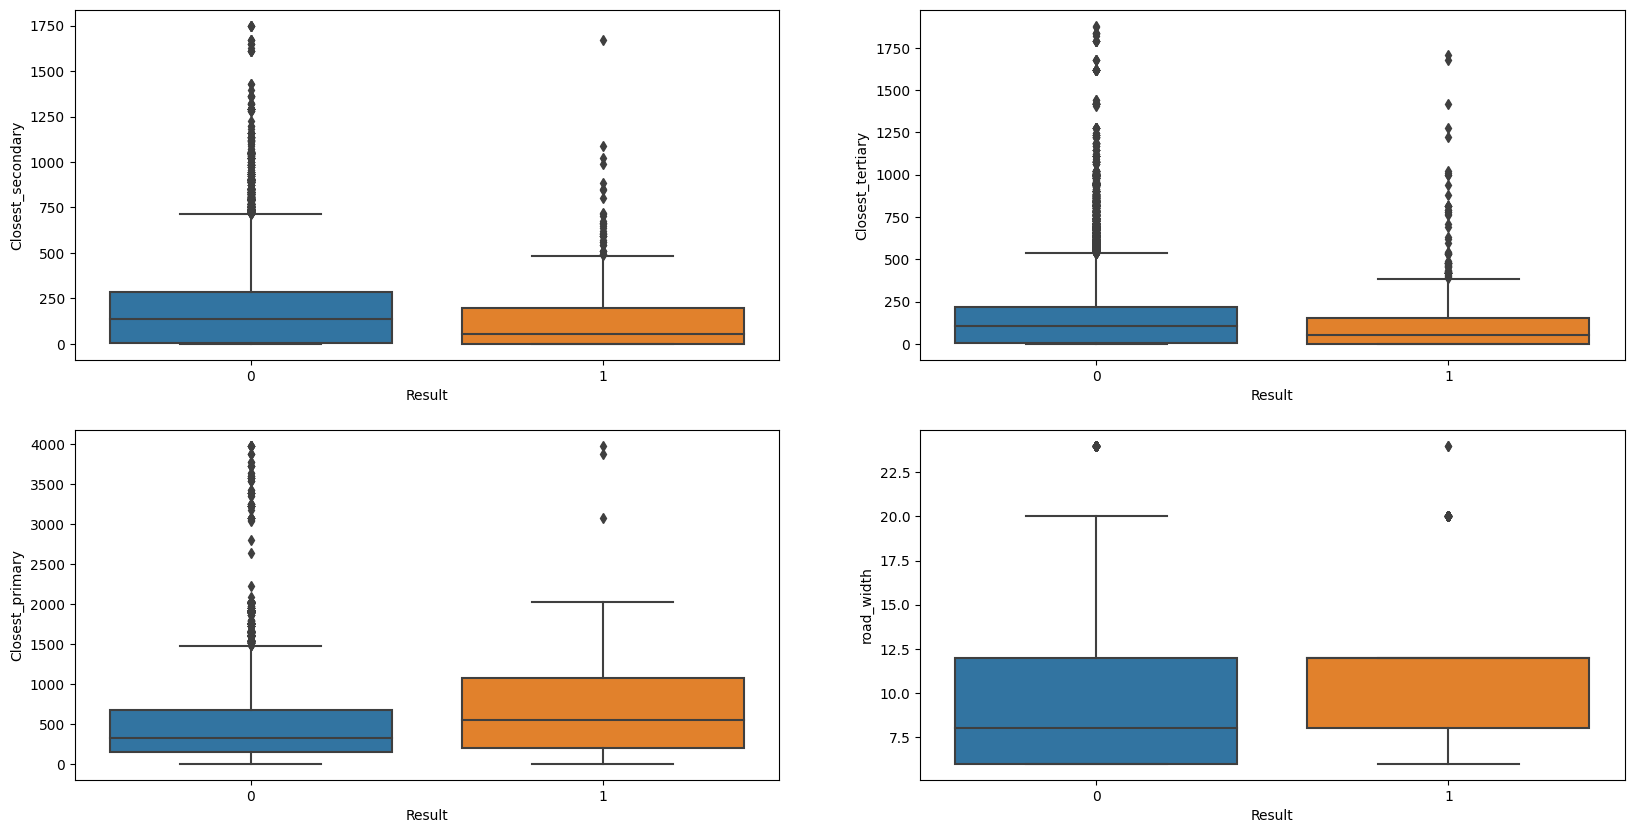

In [ ]:
_,axss = plt.subplots(2,2, figsize = [20,10])
sns.boxplot(x='Result',y='Closest_secondary',data=gpd_crime_vs,ax=axss[0][0])
sns.boxplot(x='Result',y='Closest_tertiary',data=gpd_crime_vs,ax=axss[0][1])
sns.boxplot(x='Result',y='Closest_primary',data=gpd_crime_vs,ax=axss[1][0])
sns.boxplot(x='Result',y='road_width',data=gpd_crime_vs,ax=axss[1][1])

In [ ]:
dropy = ['Incident Time','Incident Year','Incident Day of Week','Report Type Code','Incident Category','Incident Subcategory','Resolution','Intersection','Police District','Analysis Neighborhood',
        'Supervisor District 2012','Latitude','Longitude','Point','ESNCAG - Boundary File','geometry','year','minute','place_id','osm_type','osm_id','lat','lon','display_name',
        'class','type','Crime_Location','the_geom_left','districtname','gen','index_right','the_geom_right','OBJECTID','FIPSSTCO','TRT2000','STFID','TRACTID','STATE','COUNTY',
        'TRACT']
crime_md = gpd_crime_fnl.drop(dropy, axis = 1)

In [ ]:
crime_md.dtypes

Neighborhoods        float64
month                  int64
day                    int64
hour                   int64
Result                 int64
importance           float64
Closest_highway      float64
Closest_primary      float64
Closest_secondary    float64
Closest_tertiary     float64
builidng_nn1         float64
road_width             int64
rate_BS              float64
POP2000                int64
WHITE                  int64
BLACK                  int64
AMERI_ES               int64
ASIAN                  int64
HAWN_PI                int64
OTHER                  int64
MULT_RACE              int64
HISPANIC               int64
MALES                  int64
FEMALES                int64
AGE_UNDER5             int64
AGE_5_17               int64
AGE_18_21              int64
AGE_22_29              int64
AGE_30_39              int64
AGE_40_49              int64
AGE_50_64              int64
AGE_65_UP              int64
MED_AGE              float64
MED_AGE_M            float64
MED_AGE_F     

# Model Construction

In [ ]:
crime_md.fillna(0, inplace=True)

In [ ]:
X = crime_md.drop(['Result'],axis = 1)
y = crime_md['Result']

In [ ]:
from sklearn import model_selection as mdslct
X_train, X_test, y_train, y_test = mdslct.train_test_split(X, y, test_size = 0.25, stratify= y, random_state= 1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 21165 observation with 52 features
test data has 7055 observation with 52 features


In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

classifier_rd = RandomForestClassifier()
classifier_KNN = KNeighborsClassifier()
classifier_lr = LogisticRegression()

In [ ]:
classifier_rd.fit(X_train,y_train)
classifier_rd.predict(X_test)
classifier_rd.score(X_test,y_test)

In [ ]:
classifier_KNN.fit(X_train,y_train)
classifier_KNN.predict(X_test)
classifier_KNN.score(X_test,y_test)

In [ ]:
classifier_lr.fit(X_train,y_train,sample_weight=1)
classifier_lr.predict(X_test)
classifier_lr.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
def print_grid_search_metrics(gs):
  print("best_score =" + str(gs.best_score_))
  print('best_parameter set:')
  best_parameter = gs.best_params_
  for param_name in sorted(best_parameter.keys()):
    print(param_name + ':' + str(best_parameter[param_name]))

In [ ]:
#to find the optimal hyperparamater
#penalty is the way of regularization, C is the weight for penalty
parameters = {
    'penalty':('l2','l1'), 
    'C':(0.01, 0.05, 0.1, 0.2, 1,1.1,1.2)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1, 1.1, 1.2),
                         'penalty': ('l2', 'l1')})

In [ ]:
print(print_grid_search_metrics(Grid_LR))

best_score =0.9539333805811481
best_parameter set:
C:0.01
penalty:l2
None


In [ ]:
best_LR_model = Grid_LR.best_estimator_

In [ ]:
best_LR_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
best_LR_model.score(X_test,y_test)

0.9539333805811481

In [ ]:
# optimal hyperparameter for KNN
parameters = {
    'n_neighbors':[1,3,5,7]
} #the name of parameters should match that in KNN
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters,cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7]})

In [ ]:
print(print_grid_search_metrics(Grid_KNN))

best_score =0.9526104417670682
best_parameter set:
n_neighbors:7
None


In [ ]:
best_KNN_model = Grid_KNN.best_estimator_

In [ ]:
best_KNN_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
best_KNN_model.score(X_test,y_test)

0.9523742026931254

In [ ]:
# optimal hyperparameter for Random Forest
parameters = {
    'n_estimators' : [50,60,80,100],
    'max_depth': [1,5,8,10]
}
Grid_RM = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
Grid_RM.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 8, 10],
                         'n_estimators': [50, 60, 80, 100]})

In [ ]:
print(print_grid_search_metrics(Grid_RM))

best_score =0.9581384360973304
best_parameter set:
max_depth:10
n_estimators:80
None


In [ ]:
best_RM_model = Grid_RM.best_estimator_

In [ ]:
best_RM_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
best_RM_model.score(X_test,y_test)

0.9587526576895818

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy = (tp+ tn)/(tp + tn + fp + fn + 0.0)
    precision = tp/(tp + fp + 0.0)
    recall = tp/(tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ()

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

In [ ]:
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RM_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

Random Forest
Accuracy is: 0.9587526576895818
precision is: 0.7931034482758621
recall is: 0.14153846153846153

Logistic Regression
Accuracy is: 0.9539333805811481
precision is: nan
recall is: 0.0

K nearest neighbor
Accuracy is: 0.9523742026931254
precision is: 0.44554455445544555
recall is: 0.13846153846153847



<ipython-input-137-0380deb71ead>:13: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp + fp + 0.0)


In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics
#ROC for Random Forest
y_pred_rm = best_RM_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rm)

In [ ]:
best_RM_model.predict_proba(X_test)

array([[0.9804783 , 0.0195217 ],
       [0.96240263, 0.03759737],
       [0.98051001, 0.01948999],
       ...,
       [0.93483543, 0.06516457],
       [0.97694558, 0.02305442],
       [0.97324386, 0.02675614]])

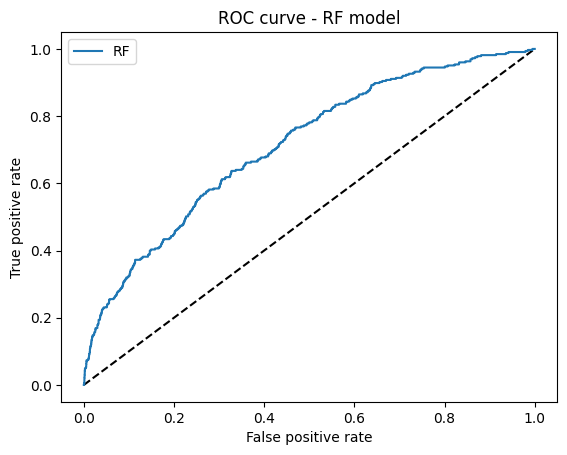

In [ ]:
# ROC curve of Random Forest result
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.7818637558578123

In [ ]:
#ROC for Logistic Regression 
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_lr)

In [ ]:
best_LR_model.predict_proba(X_test)

array([[0.96862073, 0.03137927],
       [0.96606054, 0.03393946],
       [0.95716253, 0.04283747],
       ...,
       [0.94351064, 0.05648936],
       [0.92430863, 0.07569137],
       [0.92842141, 0.07157859]])

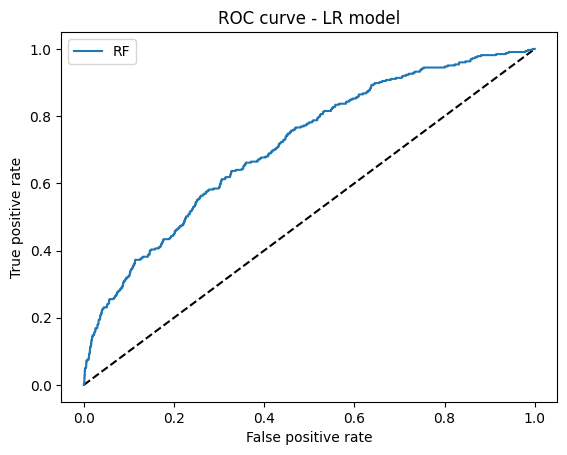

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR model')
plt.legend(loc='best')
plt.show()

In [ ]:
metrics.auc(fpr_rf,tpr_rf)

0.7121924791404731

In [ ]:
x_corr = X.copy()
scaler = StandardScaler()
X_L1 = scaler.fit_transform(x_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.04, solver='liblinear')
LRmodel_l1.fit(X_L1,y)

indices = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print ("Logistic Regression (L1) Coefficients")
for ind in range(x_corr.shape[1]):
  print ("{0} : {1}".format(x_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]], 4)))

Logistic Regression (L1) Coefficients
MED_AGE_M : 0.3342
WHITE : -0.2047
Closest_secondary : -0.2016
Closest_primary : 0.1925
Closest_tertiary : -0.1874
rate_BS : -0.1429
ztype : 0.123
HAWN_PI : 0.1183
AGE_18_21 : 0.1173
OTHER : 0.1098
VACANT : 0.1073
ASIAN : 0.0678
AGE_65_UP : -0.0657
month : -0.0526
hour : -0.0477
OWNER_OCC : -0.0447
HSEHLD_1_F : -0.0366
Neighborhoods : -0.0362
MULT_RACE : -0.0351
HSEHLD_1_M : -0.0249
Closest_highway : 0.0211
rtype : 0.0193
BLACK : -0.0161
RENTER_OCC : 0.0
importance : 0.0
builidng_nn1 : 0.0
road_width : 0.0
RURAL : 0.0
POP2000 : 0.0
URBAN : 0.0
AMERI_ES : 0.0
day : 0.0
HSE_UNITS : 0.0
FAMILIES : 0.0
HISPANIC : 0.0
FHH_CHILD : 0.0
MHH_CHILD : 0.0
MARHH_NO_C : 0.0
MARHH_CHD : 0.0
AVE_HH_SZ : 0.0
HOUSEHOLDS : 0.0
MED_AGE_F : 0.0
AVE_FAM_SZ : 0.0
MED_AGE : 0.0
AGE_50_64 : 0.0
AGE_40_49 : 0.0
AGE_30_39 : 0.0
AGE_22_29 : 0.0
AGE_5_17 : 0.0
AGE_UNDER5 : 0.0
FEMALES : 0.0
MALES : 0.0


In [ ]:
scaler = StandardScaler()
X_L2 = scaler.fit_transform(x_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.04, solver='liblinear')
LRmodel_l2.fit(X_L2,y)

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in range(x_corr.shape[1]):
  print ("{0} : {1}".format(x_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]], 4)))

Logistic Regression (L2) Coefficients
MED_AGE_M : 0.3263
HSEHLD_1_M : -0.2878
WHITE : -0.2381
AGE_5_17 : -0.2108
rate_BS : -0.2069
Closest_secondary : -0.2057
ASIAN : 0.196
MARHH_NO_C : 0.1924
Closest_primary : 0.1819
HAWN_PI : 0.1792
Closest_tertiary : -0.1763
AVE_HH_SZ : -0.1724
VACANT : 0.1557
AVE_FAM_SZ : 0.1522
AGE_65_UP : -0.1417
OTHER : 0.1396
MARHH_CHD : -0.1302
AGE_UNDER5 : 0.1262
AGE_18_21 : 0.1249
MULT_RACE : -0.1247
HISPANIC : 0.121
ztype : 0.1203
AGE_40_49 : 0.1187
MHH_CHILD : -0.1183
HSEHLD_1_F : -0.1088
AMERI_ES : 0.0906
AGE_50_64 : -0.0891
Closest_highway : 0.0882
road_width : -0.0823
MED_AGE : 0.0727
hour : -0.0718
MED_AGE_F : -0.067
month : -0.0657
HSE_UNITS : 0.0609
RENTER_OCC : 0.059
Neighborhoods : -0.0553
FHH_CHILD : 0.0535
HOUSEHOLDS : 0.0487
rtype : 0.0418
AGE_22_29 : 0.0297
AGE_30_39 : 0.0292
MALES : -0.0243
POP2000 : -0.0209
OWNER_OCC : -0.0185
FEMALES : -0.0151
BLACK : 0.015
FAMILIES : -0.0093
day : -0.0067
builidng_nn1 : -0.0
URBAN : 0.0
RURAL : 0.0
importan

In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(x_corr, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(x_corr.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
day : 0.221
hour : 0.2031
month : 0.1718
Closest_primary : 0.0668
Closest_tertiary : 0.0593
Closest_secondary : 0.0564
Closest_highway : 0.0555
Neighborhoods : 0.0167
ztype : 0.0133
MED_AGE : 0.0076
rate_BS : 0.0076
road_width : 0.0074
MED_AGE_M : 0.0072
rtype : 0.0066
OWNER_OCC : 0.0053
VACANT : 0.0042
MULT_RACE : 0.004
ASIAN : 0.0037
MED_AGE_F : 0.0036
FEMALES : 0.0036
AGE_22_29 : 0.0036
AMERI_ES : 0.0035
AGE_40_49 : 0.0032
HSEHLD_1_M : 0.0031
MALES : 0.0031
POP2000 : 0.003
HISPANIC : 0.003
AGE_UNDER5 : 0.0029
HSEHLD_1_F : 0.0029
FAMILIES : 0.0029
BLACK : 0.0028
RENTER_OCC : 0.0028
HSE_UNITS : 0.0028
MARHH_NO_C : 0.0027
AGE_18_21 : 0.0026
HOUSEHOLDS : 0.0026
AGE_65_UP : 0.0026
AGE_50_64 : 0.0026
WHITE : 0.0025
OTHER : 0.0025
MARHH_CHD : 0.0025
AGE_5_17 : 0.0025
FHH_CHILD : 0.0024
AGE_30_39 : 0.0024
MHH_CHILD : 0.0023
AVE_HH_SZ : 0.0021
HAWN_PI : 0.0021
AVE_FAM_SZ : 0.0017
builidng_nn1 : 0.0
URBAN : 0.0
RURAL : 0.0
importance : 0.0
